The following cell contains common imports and definitions. Run it first.

In [8]:
import matplotlib.pyplot as plt
import tikzplotlib
import pickle
import numpy as np

ALGORITHMS = {
    'random': 'Random',
    'tribler': 'Tribler',
    'dinx_s': 'DINX (s)',
    'dinx': 'DINX',
    'panache': 'Panaché',
    'maay': 'MAAY',
    'grank': 'G-Rank',
    'ltr': 'MARank'
}

def tikzplotlib_fix_ncols(obj):
    """Workaround function to fix legend column issue before saving with tikzplotlib."""
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    if hasattr(obj, 'gcf'):
        fig = obj.gcf()
        for ax in fig.get_axes():
            if hasattr(ax, 'legend_') and ax.legend_ is not None:
                if hasattr(ax.legend_, "_ncols"):
                    ax.legend_._ncol = ax.legend_._ncols
    else:
        for child in obj.get_children():
            tikzplotlib_fix_ncols(child)

# Dataset Analysis

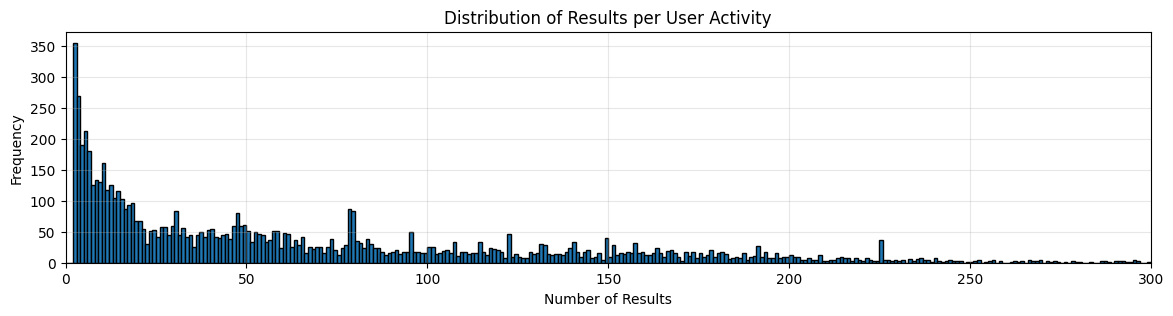

Number of activities with only one result: 814
Percentage of activities with only one result: 10.59%
Mean number of results per activity: 65.34
Median number of results per activity: 43.00


In [40]:
# Plot distribution of results per user activity
plt.figure(figsize=(14, 3))

with open('user_activities.pkl', 'rb') as f:
    user_activities = pickle.load(f)

result_counts = [len(ua.results) for ua in user_activities]

xmax = 300
plt.hist(result_counts, bins=range(xmax+1), edgecolor='black')
plt.xlabel('Number of Results')
plt.ylabel('Frequency') 
plt.title('Distribution of Results per User Activity')
plt.grid(True, alpha=0.3)
plt.xlim(0, xmax)
plt.show()

# Count activities with only one result
single_result_count = sum(1 for ua in user_activities if len(ua.results) < 5)
print(f"Number of activities with only one result: {single_result_count}")
print(f"Percentage of activities with only one result: {single_result_count/len(user_activities)*100:.2f}%")
# Calculate and print mean and median of result counts
mean_results = np.mean(result_counts)
median_results = np.median(result_counts)
print(f"Mean number of results per activity: {mean_results:.2f}")
print(f"Median number of results per activity: {median_results:.2f}")

# Chosen Ranking Positions

769
769


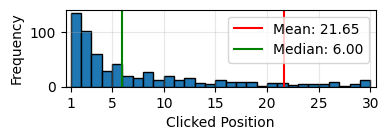

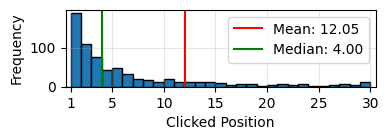

In [41]:
def plot_chosen_indices(ranking_algo):
    with open(f'results/reranked_activities/{ranking_algo}.pkl', 'rb') as f:
        user_activities = pickle.load(f)
        print(len(user_activities))
        
    chosen_indices = []
    for ua in user_activities:
        if ua.chosen_result is None:
            continue
        try:
            chosen_idx = next(i for i, r in enumerate(ua.results) if r.infohash == ua.chosen_result.infohash) + 1
            chosen_indices.append(chosen_idx)
        except StopIteration:
            # Skip if the chosen result isn't found in results list
            continue

    avg_chosen_index = np.mean(chosen_indices)
    median_chosen_index = np.median(chosen_indices)

    plt.figure(figsize=(4, 1))
    xlimit = 30
    plt.hist([x for x in chosen_indices if x <= xlimit], bins=range(xlimit+1), edgecolor='black')
    plt.axvline(avg_chosen_index, color='red', linestyle='-', label=f'Mean: {avg_chosen_index:.2f}')
    plt.axvline(median_chosen_index, color='green', linestyle='-', label=f'Median: {median_chosen_index:.2f}')
    plt.xlabel('Clicked Position')
    plt.ylabel('Frequency')
    # plt.yscale('log')
    plt.xlim(1, None)
    plt.xlim(0.5, xlimit+0.5)
    plt.xticks([1] + list(range(5, xlimit+1, 5)))
    plt.legend()
    plt.grid(True, alpha=0.3)
    tikzplotlib_fix_ncols(plt)
    tikzplotlib.save(
        f"results/tex/chosen_indices_{ranking_algo.lower()}.tex",
        axis_width=r'\columnwidth',
        axis_height=r'4cm')
    
plot_chosen_indices('tribler')
plot_chosen_indices('ltr')

# Performance with Context Size

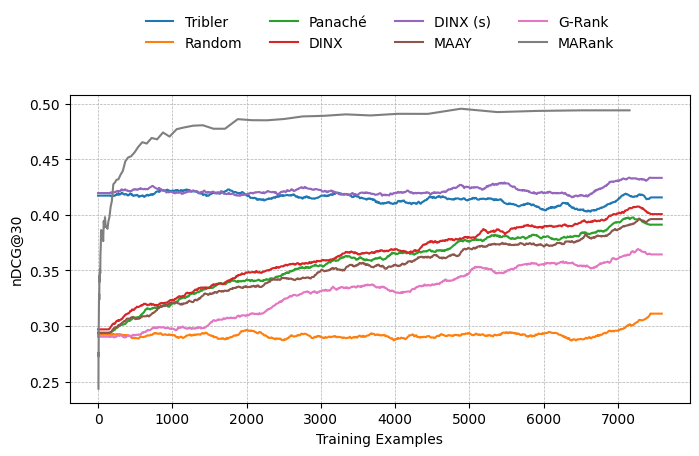

In [104]:
import matplotlib.pyplot as plt
import tikzplotlib
import numpy as np
import pickle

with open('results/context_ndcgs.pkl', 'rb') as f:
    all_ndcgs = pickle.load(f)

with open('results/context_ndcgs_ltr.pkl', 'rb') as f:
    all_ndcgs.update(pickle.load(f))

desired_k = 30
filtered_ndcgs = {}
for algo_name, index_dict in all_ndcgs.items():
    filtered_ndcgs[algo_name] = {x: metrics[desired_k] for x, metrics in index_dict.items() if desired_k in metrics}

all_ndcgs = filtered_ndcgs

###############################################################################
# Smoothing Functions
###############################################################################

def simple_moving_average(data, window_size):
    """Apply simple moving average with a fixed window size, ensuring length consistency."""
    if len(data) < window_size:
        return np.array(data)  # Return original if not enough data points
    smoothed = np.convolve(data, np.ones(window_size) / window_size, mode='valid')
    
    # Pad to maintain original length
    pad_size = (len(data) - len(smoothed)) // 2
    smoothed = np.pad(smoothed, (pad_size, len(data) - len(smoothed) - pad_size), mode='edge')
    
    return smoothed

def log_adaptive_moving_average(data, x, min_window, max_window):
    """Apply adaptive smoothing where the window size grows logarithmically with x."""
    smoothed_data = []
    x_min = x[0] if x[0] != 0 else 1e-10  # Avoid division by zero
    for i in range(len(data)):
        log_x = np.log1p(x[i] - x_min)
        max_log_x = np.log1p(x[-1] - x_min)
        window_size = int(min_window + (max_window - min_window) * (log_x / max_log_x))
        window_size = max(1, window_size)
        
        start_idx = max(0, i - window_size // 2)
        end_idx = min(len(data), i + window_size // 2)
        smoothed_data.append(np.mean(data[start_idx:end_idx]))
    return np.array(smoothed_data)

def downsample_data(x, y, num_points=1000):
    """Downsample (x, y) to at most `num_points` points while preserving trends."""
    if len(x) <= num_points:
        return x, y  # No need to downsample

    indices = np.round(np.linspace(0, len(x) - 1, num_points)).astype(int)
    return [x[i] for i in indices], [y[i] for i in indices]


###############################################################################
# Plotting Code
###############################################################################

fig, ax1 = plt.subplots(figsize=(8, 4))

window_size = 300  # Fixed window size for standard smoothing
min_window_size = 5
max_window_size = 20  # Adaptive smoothing for 'ltr'

# Plot all algorithms on the same axis
for algo_name, index_dict in all_ndcgs.items():
    x_filtered = sorted(index_dict.keys())
    y_vals = [index_dict[x] for x in x_filtered]
    
    if "ltr" in algo_name.lower():
        smoothed_vals = log_adaptive_moving_average(y_vals, x_filtered, min_window_size, max_window_size)
    else:
        smoothed_vals = simple_moving_average(y_vals, window_size)
    
    x_downsampled, y_downsampled = downsample_data(x_filtered, smoothed_vals, num_points=1000)
    ax1.plot(x_downsampled, y_downsampled, label=ALGORITHMS[algo_name])

ax1.set_xlabel('Training Examples')
ax1.set_ylabel(f'nDCG@{desired_k or "max"}')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Combine legends
ax1.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.3),
    ncol=4,
    frameon=False
)


tikzplotlib_fix_ncols(plt)
tikzplotlib.save("results/tex/context_ndcgs.tex", axis_width=r'\columnwidth', axis_height=r'6cm')

plt.show()


In [99]:
list(all_ndcgs['ltr'].keys())

[5,
 6,
 7,
 8,
 9,
 10,
 12,
 14,
 16,
 18,
 20,
 23,
 26,
 29,
 32,
 36,
 40,
 45,
 50,
 56,
 62,
 69,
 76,
 84,
 93,
 103,
 114,
 126,
 139,
 153,
 169,
 186,
 205,
 226,
 249,
 274,
 302,
 333,
 367,
 404,
 445,
 490,
 540,
 595,
 655,
 721,
 794,
 874,
 962,
 1059,
 1165,
 1282,
 1411,
 1553,
 1709,
 1880,
 2069,
 2276,
 2504,
 2755,
 3031,
 3335,
 3669,
 4036,
 4440,
 4885,
 5374,
 5912,
 6504,
 7155]

In [39]:
len(all_ndcgs['ltr'])# First, ensure that the three algorithms exist in your results
for algo in ['ltr', 'Tribler', 'DINX (s)']:
    if algo not in all_ndcgs:
        raise ValueError(f"Algorithm '{algo}' is not in your data!")

# Get the set of training sample counts common to all three algorithms.
common_x = sorted(
    set(all_ndcgs['ltr'].keys()) &
    set(all_ndcgs['Tribler'].keys()) &
    set(all_ndcgs['DINX (s)'].keys())
)

# Extract the corresponding nDCG values for each algorithm.
ltr_ndcg      = np.array([all_ndcgs['ltr'][x] for x in common_x])
tribler_ndcg  = np.array([all_ndcgs['Tribler'][x] for x in common_x])
dinx_s_ndcg   = np.array([all_ndcgs['DINX (s)'][x] for x in common_x])

# Option 1: Check the raw (unsmoothed) data for the crossover point.
crossover_found = False
for x, ltr_val, trib_val, dinx_val in zip(common_x, ltr_ndcg, tribler_ndcg, dinx_s_ndcg):
    if ltr_val > trib_val and ltr_val > dinx_val:
        print(f"Raw Data: ltr overtakes tribler and dinx_s at {x} training examples.")
        print(f"nDCG@{desired_k}: ltr = {ltr_val:.3f}, tribler = {trib_val:.3f}, dinx_s = {dinx_val:.3f}")
        crossover_found = True
        break

if not crossover_found:
    print("In the raw data, ltr did not overtake both tribler and dinx_s.")

# Option 2: If you want to check the smoothed curves,
# you can apply your smoothing function to each algorithm’s data.
def get_smoothed_values(algo_key, min_window=min_window_size, max_window=max_window_size):
    # Get sorted x values and corresponding y values
    x_vals = sorted(all_ndcgs[algo_key].keys())
    y_vals = [all_ndcgs[algo_key][x] for x in x_vals]
    return x_vals, log_adaptive_moving_average(y_vals, x_vals, min_window, max_window)

# Retrieve smoothed curves.
x_ltr, ltr_smoothed       = get_smoothed_values('ltr')
x_tribler, tribler_smoothed = get_smoothed_values('Tribler')
x_dinx, dinx_smoothed     = get_smoothed_values('DINX (s)')

# For simplicity, assume that the x-values are (approximately) the same.
# (If not, you might need to interpolate the smoothed values to common x positions.)
min_length = min(len(x_ltr), len(x_tribler), len(x_dinx))
x_common = x_ltr[:min_length]
ltr_s = ltr_smoothed[:min_length]
tribler_s = tribler_smoothed[:min_length]
dinx_s = dinx_smoothed[:min_length]

crossover_found_smoothed = False
for x, ltr_val, trib_val, dinx_val in zip(x_common, ltr_s, tribler_s, dinx_s):
    if ltr_val > trib_val and ltr_val > dinx_val:
        print(f"Smoothed Data: ltr overtakes tribler and dinx_s at {x} training examples.")
        print(f"Smoothed nDCG@{desired_k}: ltr = {ltr_val:.3f}, tribler = {trib_val:.3f}, dinx_s = {dinx_val:.3f}")
        crossover_found_smoothed = True
        break

if not crossover_found_smoothed:
    print("In the smoothed data, ltr did not overtake both tribler and dinx_s.")


Raw Data: ltr overtakes tribler and dinx_s at 26 training examples.
nDCG@30: ltr = 0.434, tribler = 0.415, dinx_s = 0.372
Smoothed Data: ltr overtakes tribler and dinx_s at 186 training examples.
Smoothed nDCG@30: ltr = 0.424, tribler = 0.419, dinx_s = 0.418


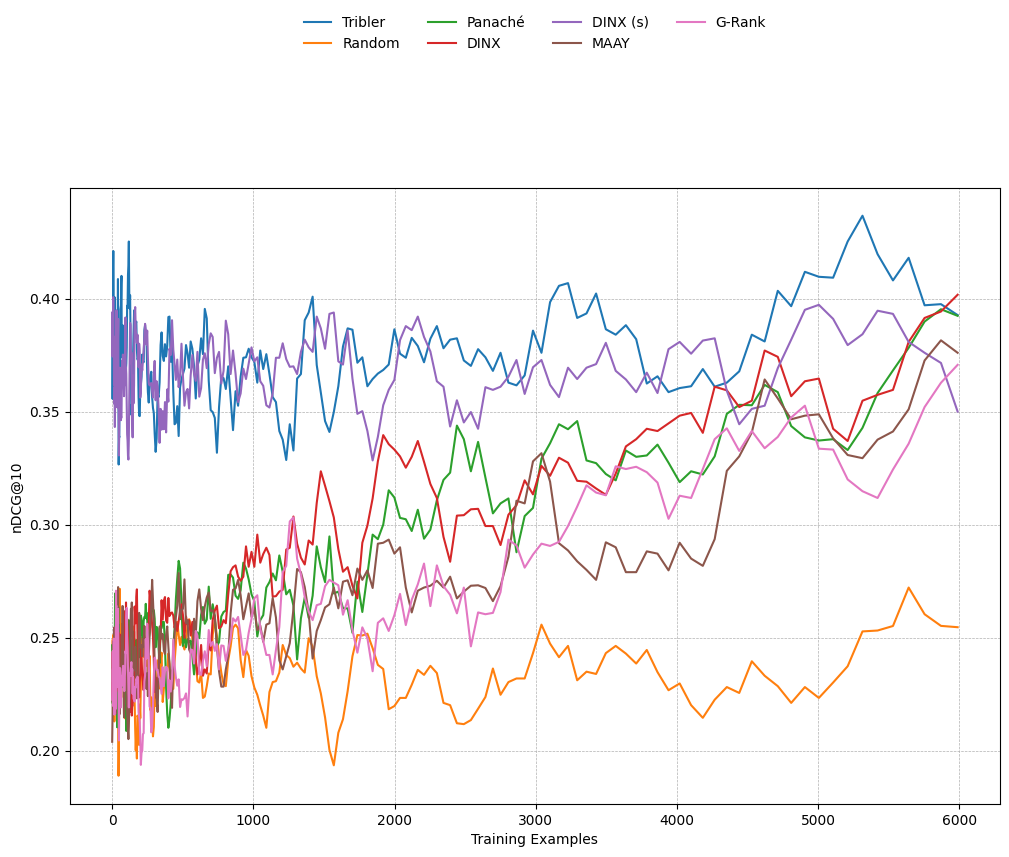

In [126]:
import matplotlib.pyplot as plt
import tikzplotlib
import numpy as np
import pandas as pd

plt.figure(figsize=(12, 8))

for algo_name, index_dict in all_ndcgs.items():
    # Get original x and y values
    x_orig = sorted(index_dict.keys())
    y_orig = [index_dict[x] for x in x_orig]
    
    # Create a pandas Series for easy rolling average
    s = pd.Series(y_orig)
    window = 5  # Adjust window size as needed
    y_smooth = s.rolling(window=window, center=True, min_periods=1).mean()
    
    plt.plot(x_orig, y_smooth, label=algo_name)

plt.xlabel('Training Examples')
plt.ylabel(f'nDCG@{desired_k}' if desired_k is not None else 'nDCG')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.3),
    ncol=4,
    frameon=False
)

# Your existing tikzplotlib fixes and saving
tikzplotlib_fix_ncols(plt)
tikzplotlib.save("ndcg_plot.tex", axis_width=r'\columnwidth', axis_height=r'6cm')

# Decentralized Setting

Statistics for change from local_ndcg.30 to gossip_ndcg.30:

Algorithm: ltr
  Min Change: -0.2200
  Max Change: 0.5250
  Mean Change: 0.0155
  Variance: 0.020645

Algorithm: tribler
  Min Change: 0.0000
  Max Change: 0.0000
  Mean Change: 0.0000
  Variance: 0.000000

Algorithm: random
  Min Change: -0.1760
  Max Change: 0.2180
  Mean Change: 0.0075
  Variance: 0.008824

Algorithm: panache
  Min Change: -0.1300
  Max Change: 0.1560
  Mean Change: 0.0203
  Variance: 0.004617

Algorithm: dinx
  Min Change: -0.1710
  Max Change: 0.2040
  Mean Change: 0.0023
  Variance: 0.005858

Algorithm: dinx_s
  Min Change: -0.0510
  Max Change: 0.1950
  Mean Change: 0.0038
  Variance: 0.002281

Algorithm: maay
  Min Change: -0.1230
  Max Change: 0.1160
  Mean Change: -0.0098
  Variance: 0.003171

Algorithm: grank
  Min Change: -0.1440
  Max Change: 0.4800
  Mean Change: 0.0874
  Variance: 0.020067


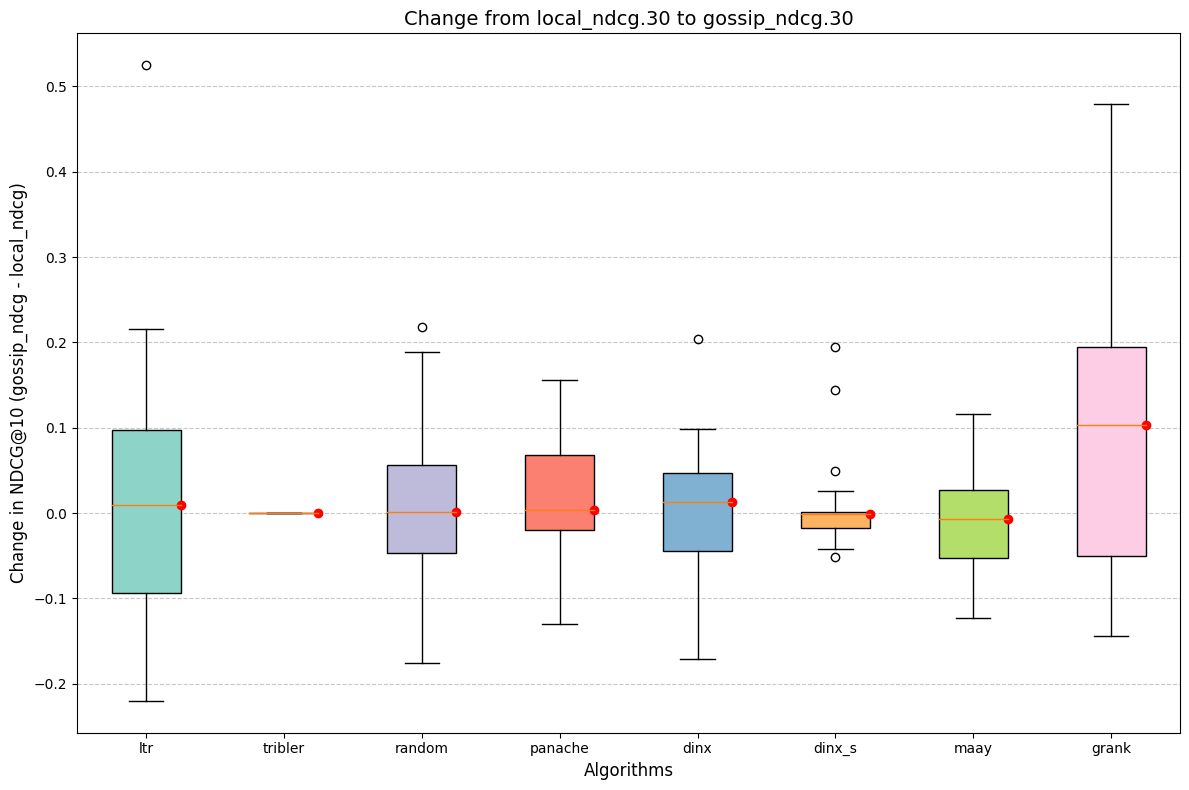

In [59]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Define the value of k
k = "30"

# Load the JSON data
with open("results/p2p.json", "r") as f:
    data = json.load(f)

# Dictionary to hold the changes for each algorithm
change_data = {}
statistics = {}

# Iterate over each algorithm in the data
for algorithm, items in data.items():
    changes = []
    for item in items:
        # Ensure both 'local_ndcg' and 'gossip_ndcg' exist and contain the key k
        if 'local_ndcg' in item and 'gossip_ndcg' in item:
            local = item['local_ndcg'].get(k)
            gossip = item['gossip_ndcg'].get(k)
            if local is not None and gossip is not None:
                change = gossip - local
                changes.append(change)
    
    # Store the changes for the current algorithm
    change_data[algorithm] = changes
    
    # Calculate statistics if there are any changes
    if changes:
        changes_np = np.array(changes)
        statistics[algorithm] = {
            'min': np.min(changes_np),
            'max': np.max(changes_np),
            'mean': np.mean(changes_np),
            'variance': np.var(changes_np)
        }
    else:
        statistics[algorithm] = {
            'min': None,
            'max': None,
            'mean': None,
            'variance': None
        }

# Print the statistics
print(f"Statistics for change from local_ndcg.{k} to gossip_ndcg.{k}:")
for algo, stats in statistics.items():
    print(f"\nAlgorithm: {algo}")
    if stats['min'] is not None:
        print(f"  Min Change: {stats['min']:.4f}")
        print(f"  Max Change: {stats['max']:.4f}")
        print(f"  Mean Change: {stats['mean']:.4f}")
        print(f"  Variance: {stats['variance']:.6f}")
    else:
        print("  No valid data to compute statistics.")

# Prepare data for box plot
data_to_plot = [change_data[algo] for algo in ALGORITHMS.keys()]

# Create a vertical box plot with algorithms on the x-axis
plt.figure(figsize=(12, 8))  # Adjusted figure size for better readability
box = plt.boxplot(data_to_plot, vert=True, patch_artist=True, labels=ALGORITHMS.keys())

# Customize box plot appearance
colors = plt.cm.Set3.colors  # Use a colormap with distinct colors
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Optionally, add mean markers
for median in box['medians']:
    x, y = median.get_xydata()[1]
    plt.plot(x, y, 'ro')  # Red dot for median

plt.title(f'Change from local_ndcg.{k} to gossip_ndcg.{k}', fontsize=14)
plt.ylabel('Change in NDCG@10 (gossip_ndcg - local_ndcg)', fontsize=12)
plt.xlabel('Algorithms', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Statistics for local_ndcg.30 and gossip_ndcg.30:

Algorithm: random
  Local NDCG:
    Min NDCG@30: 0.0000
    Max NDCG@30: 1.0000
    Mean NDCG@30: 0.2849
    Variance: 0.043760
  Gossip NDCG:
    Min NDCG@30: 0.0000
    Max NDCG@30: 1.0000
    Mean NDCG@30: 0.2708
    Variance: 0.042406

Algorithm: tribler
  Local NDCG:
    Min NDCG@30: 0.0000
    Max NDCG@30: 1.0000
    Mean NDCG@30: 0.4086
    Variance: 0.056585
  Gossip NDCG:
    Min NDCG@30: 0.0000
    Max NDCG@30: 1.0000
    Mean NDCG@30: 0.4086
    Variance: 0.056585

Algorithm: dinx_s
  Local NDCG:
    Min NDCG@30: 0.0000
    Max NDCG@30: 1.0000
    Mean NDCG@30: 0.4042
    Variance: 0.051608
  Gossip NDCG:
    Min NDCG@30: 0.0000
    Max NDCG@30: 1.0000
    Mean NDCG@30: 0.4042
    Variance: 0.051608

Algorithm: dinx
  Local NDCG:
    Min NDCG@30: 0.0000
    Max NDCG@30: 1.0000
    Mean NDCG@30: 0.3713
    Variance: 0.059158
  Gossip NDCG:
    Min NDCG@30: 0.0000
    Max NDCG@30: 1.0000
    Mean NDCG@30: 0.3938
    Variance: 0

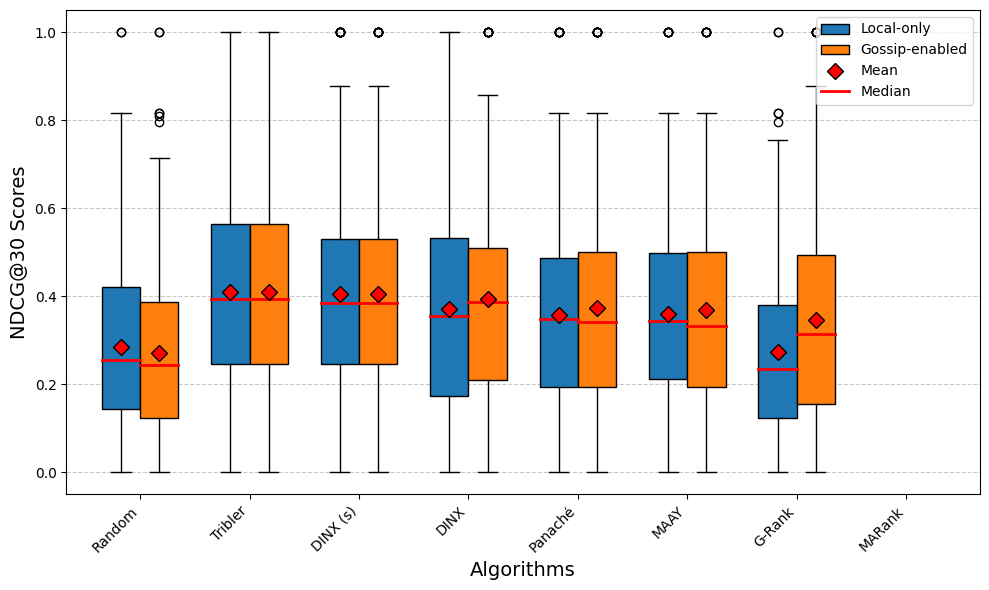

In [2]:
import json
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind

# Define the value of k
k = "30"

# Load the JSON data
with open("results/p2p.json", "r") as f:
    data = json.load(f)
with open("results/p2p_ltr.json", "r") as f:
    data['ltr'] = json.load(f)

# Dictionaries to hold the local_ndcg and gossip_ndcg values for each algorithm
local_ndcg_data = {}
gossip_ndcg_data = {}
statistics = {}

# Iterate over each algorithm in ALGORITHMS
for algorithm, algorithm_name in ALGORITHMS.items():
    if algorithm not in data:
        print(f"Warning: '{algorithm}' not found in the data. Skipping.")
        continue  # Skip to the next algorithm if not found
    
    items = data[algorithm]
    local_values = []
    gossip_values = []
    
    for item in items:
        # Collect 'local_ndcg' values
        if 'local_ndcg' in item:
            local = item['local_ndcg'].get(k)
            if local is not None:
                local_values.append(local)
        
        # Collect 'gossip_ndcg' values
        if 'gossip_ndcg' in item:
            gossip = item['gossip_ndcg'].get(k)
            if gossip is not None:
                gossip_values.append(gossip)
    
    # Store the values for the current algorithm
    local_ndcg_data[algorithm] = local_values
    gossip_ndcg_data[algorithm] = gossip_values
    
    # Calculate statistics if there are any values
    if local_values or gossip_values:
        statistics[algorithm] = {}
        
        if local_values:
            local_np = np.array(local_values)
            statistics[algorithm]['local'] = {
                'min': np.min(local_np),
                'max': np.max(local_np),
                'mean': np.mean(local_np),
                'variance': np.var(local_np)
            }
        else:
            statistics[algorithm]['local'] = {
                'min': None,
                'max': None,
                'mean': None,
                'variance': None
            }
        
        if gossip_values:
            gossip_np = np.array(gossip_values)
            statistics[algorithm]['gossip'] = {
                'min': np.min(gossip_np),
                'max': np.max(gossip_np),
                'mean': np.mean(gossip_np),
                'variance': np.var(gossip_np)
            }
        else:
            statistics[algorithm]['gossip'] = {
                'min': None,
                'max': None,
                'mean': None,
                'variance': None
            }
    else:
        statistics[algorithm] = {
            'local': {'min': None, 'max': None, 'mean': None, 'variance': None},
            'gossip': {'min': None, 'max': None, 'mean': None, 'variance': None}
        }

# Print the statistics
print(f"Statistics for local_ndcg.{k} and gossip_ndcg.{k}:")
for algo in ALGORITHMS:
    if algo not in statistics:
        continue  # Skip algorithms that were not found
    stats = statistics[algo]
    print(f"\nAlgorithm: {algo}")
    # Local NDCG Statistics
    print("  Local NDCG:")
    if stats['local']['min'] is not None:
        print(f"    Min NDCG@{k}: {stats['local']['min']:.4f}")
        print(f"    Max NDCG@{k}: {stats['local']['max']:.4f}")
        print(f"    Mean NDCG@{k}: {stats['local']['mean']:.4f}")
        print(f"    Variance: {stats['local']['variance']:.6f}")
    else:
        print("    No valid data to compute statistics.")
    
    # Gossip NDCG Statistics
    print("  Gossip NDCG:")
    if stats['gossip']['min'] is not None:
        print(f"    Min NDCG@{k}: {stats['gossip']['min']:.4f}")
        print(f"    Max NDCG@{k}: {stats['gossip']['max']:.4f}")
        print(f"    Mean NDCG@{k}: {stats['gossip']['mean']:.4f}")
        print(f"    Variance: {stats['gossip']['variance']:.6f}")
    else:
        print("    No valid data to compute statistics.")

# Combine the data for plotting: [Local, Gossip, Local, Gossip, ...]
data_to_plot = []
for algo in ALGORITHMS.keys():
    data_to_plot.append(local_ndcg_data.get(algo, []))
    data_to_plot.append(gossip_ndcg_data.get(algo, []))

# Define box positions
# Each algorithm will have two boxes: Local and Gossip
# We'll space them with a certain width offset
width = 0.35  # Width of each box
positions = []
for i in range(len(ALGORITHMS)):
    # Center position for the algorithm
    center = i + 1  # Start from 1 for better readability on x-axis
    # Positions for Local and Gossip boxes
    positions.append(center - width/2)
    positions.append(center + width/2)

# Create a vertical box plot with grouped algorithms on the x-axis
plt.figure(figsize=(10, 6))  # Increased figure width for better readability
box = plt.boxplot(
    data_to_plot,
    positions=positions,
    widths=width,
    patch_artist=True,
    showmeans=True,  # Enable mean markers
    meanprops={
        'marker': 'D',  # Diamond shape
        'markerfacecolor': 'red',
        'markeredgecolor': 'black',
        'markersize': 8
    },
    medianprops={
        'color': 'red',        # Set median line color to red
        'linewidth': 2         # Increase median line width for better visibility
    }
)

# Customize box plot appearance
colors = ['#1f77b4', '#ff7f0e']  # Colors for Local and Gossip
for i in range(len(box['boxes'])):
    box['boxes'][i].set_facecolor(colors[i % 2])

# Create custom legend
legend_elements = [
    Patch(facecolor=colors[0], edgecolor='black', label='Local-only'),
    Patch(facecolor=colors[1], edgecolor='black', label='Gossip-enabled'),
    Line2D([0], [0], marker='D', color='w', label='Mean',
           markerfacecolor='red', markeredgecolor='black', markersize=8),
    Line2D([0], [0], color='red', lw=2, label='Median')
]
plt.legend(handles=legend_elements, loc='upper right')

# Perform t-tests and display results
# For each algorithm, compare local vs gossip
print("\nT-test results:")
for algo in ALGORITHMS.keys():
    local_values = local_ndcg_data.get(algo, [])
    gossip_values = gossip_ndcg_data.get(algo, [])
    if len(local_values) > 1 and len(gossip_values) > 1:
        t_stat, p_val = ttest_ind(local_values, gossip_values, equal_var=False)
        print(f"Algorithm: {algo}\n  t-statistic: {t_stat:.4f}, p-value: {p_val:.6f}")
    else:
        print(f"Algorithm: {algo}\n  Not enough data points to perform t-test.")

# Set x-axis labels to be in the center of each algorithm's group
plt.xticks([i + 1 for i in range(len(ALGORITHMS))], ALGORITHMS.values(), rotation=45, ha='right')

plt.ylabel(f'NDCG@{k} Scores', fontsize=14)
plt.xlabel('Algorithms', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

tikzplotlib_fix_ncols(plt)
tikzplotlib.save("results/tex/p2p_ndcg.tex", axis_width=r'\columnwidth', axis_height=r'6cm')


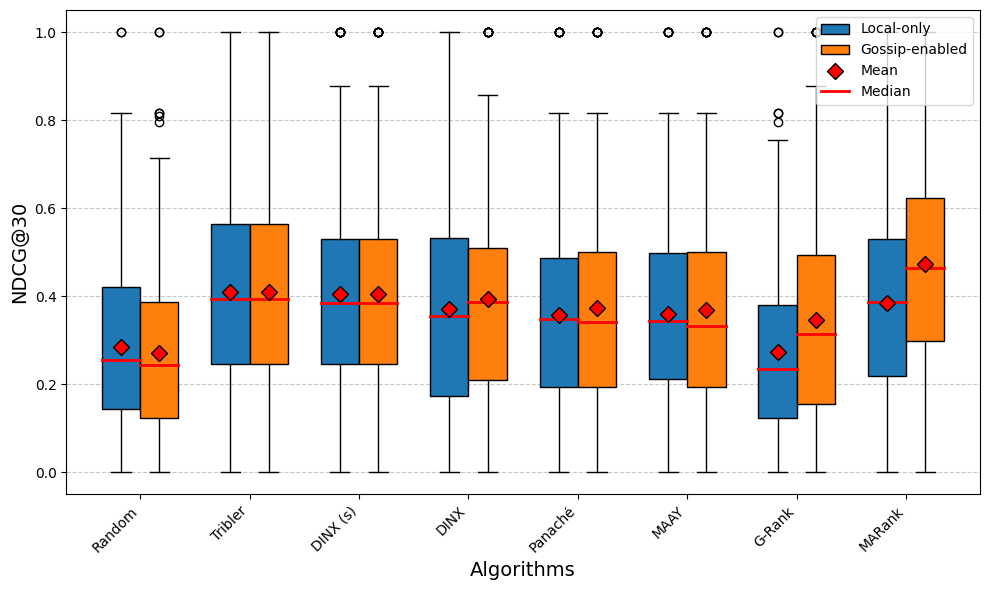

In [7]:


import matplotlib.pyplot as plt
import tikzplotlib
import pickle
import numpy as np

ALGORITHMS = {
    'random': 'Random',
    'tribler': 'Tribler',
    'dinx_s': 'DINX (s)',
    'dinx': 'DINX',
    'panache': 'Panaché',
    'maay': 'MAAY',
    'grank': 'G-Rank',
    'ltr': 'MARank'
}

import json
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind

# Define the value of k
k = "30"

# Load the JSON data
with open("results/p2p.json", "r") as f:
    data = json.load(f)
with open("results/p2p_ltr.json", "r") as f:
    data['ltr'] = json.load(f)['ltr']

# Dictionaries to hold the local_ndcg and gossip_ndcg values for each algorithm
local_ndcg_data = {}
gossip_ndcg_data = {}
statistics = {}

# Iterate over each algorithm in ALGORITHMS
for algorithm, algorithm_name in ALGORITHMS.items():
    if algorithm not in data:
        print(f"Warning: '{algorithm}' not found in the data. Skipping.")
        continue  # Skip to the next algorithm if not found
    
    items = data[algorithm]
    local_values = []
    gossip_values = []
    
    for item in items:
        # Collect 'local_ndcg' values
        if 'local_ndcg' in item:
            local = item['local_ndcg'].get(k)
            if local is not None:
                local_values.append(local)
        
        # Collect 'gossip_ndcg' values
        if 'gossip_ndcg' in item:
            gossip = item['gossip_ndcg'].get(k)
            if gossip is not None:
                gossip_values.append(gossip)
    
    # Store the values for the current algorithm
    local_ndcg_data[algorithm] = local_values
    gossip_ndcg_data[algorithm] = gossip_values
    
    # Calculate statistics if there are any values
    if local_values or gossip_values:
        statistics[algorithm] = {}
        
        if local_values:
            local_np = np.array(local_values)
            statistics[algorithm]['local'] = {
                'min': np.min(local_np),
                'max': np.max(local_np),
                'mean': np.mean(local_np),
                'variance': np.var(local_np)
            }
        else:
            statistics[algorithm]['local'] = {
                'min': None,
                'max': None,
                'mean': None,
                'variance': None
            }
        
        if gossip_values:
            gossip_np = np.array(gossip_values)
            statistics[algorithm]['gossip'] = {
                'min': np.min(gossip_np),
                'max': np.max(gossip_np),
                'mean': np.mean(gossip_np),
                'variance': np.var(gossip_np)
            }
        else:
            statistics[algorithm]['gossip'] = {
                'min': None,
                'max': None,
                'mean': None,
                'variance': None
            }
    else:
        statistics[algorithm] = {
            'local': {'min': None, 'max': None, 'mean': None, 'variance': None},
            'gossip': {'min': None, 'max': None, 'mean': None, 'variance': None}
        }

# Combine the data for plotting: [Local, Gossip, Local, Gossip, ...]
data_to_plot = []
for algo in ALGORITHMS.keys():
    data_to_plot.append(local_ndcg_data.get(algo, []))
    data_to_plot.append(gossip_ndcg_data.get(algo, []))

# Define box positions
width = 0.35  # Width of each box
positions = []
for i in range(len(ALGORITHMS)):
    center = i + 1  # Start from 1 for better readability on x-axis
    positions.append(center - width/2)
    positions.append(center + width/2)

# Create a vertical box plot with grouped algorithms on the x-axis
plt.figure(figsize=(10, 6))
box = plt.boxplot(
    data_to_plot,
    positions=positions,
    widths=width,
    patch_artist=True,
    showmeans=True,
    meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'black', 'markersize': 8},
    medianprops={'color': 'red', 'linewidth': 2}
)

colors = ['#1f77b4', '#ff7f0e']
for i in range(len(box['boxes'])):
    box['boxes'][i].set_facecolor(colors[i % 2])

plt.xticks([i + 1 for i in range(len(ALGORITHMS))], ALGORITHMS.values(), rotation=45, ha='right')
plt.ylabel(f'NDCG@{k}', fontsize=14)
plt.xlabel('Algorithms', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

legend_elements = [
    Patch(facecolor=colors[0], edgecolor='black', label='Local-only'),
    Patch(facecolor=colors[1], edgecolor='black', label='Gossip-enabled'),
    Line2D([0], [0], marker='D', color='w', label='Mean', markerfacecolor='red', markeredgecolor='black', markersize=8),
    Line2D([0], [0], color='red', lw=2, label='Median')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()

tikzplotlib_fix_ncols(plt)
tikzplotlib.save("results/tex/p2p_ndcg.tex", axis_width=r'\columnwidth', axis_height=r'6cm')


When using TikZ export, the following manual changes are needed to fix the legend:

1. Override legend attributes on axis with:
```
legend columns=4,
    legend style={
    at={(0.5,1.1)},
    anchor=south,
    draw=none,
    fill opacity=0.8,
    text opacity=1
},
```
2. Add before `\end{axis}`:
```
\addlegendimage{area legend, fill=steelblue31119180, draw=black}
\addlegendentry{Local}
\addlegendimage{area legend, fill=darkorange25512714, draw=black}
\addlegendentry{Gossip}
\addlegendimage{mark=diamond*, mark options={solid, fill=red, draw=black}, red, only marks}
\addlegendentry{Mean}
\addlegendimage{line legend, red, line width=2pt}
\addlegendentry{Median}
```